# Climate Data Collection

In [ ]:
data_folder = "../../data/raw/"
data_files = { 
    "fire_dz": "viirs-jpss1_2024_Algeria.csv",
    "fire_tn": "viirs-jpss1_2024_Tunisia.csv",
    "landcover_dz": "landcover_dz/dza_gc_adg.shp",
    "landcover_tn": "landcover_tn/tun_gc_adg.shp", 
    "landcover_legend": "landcover_dz/globcover_LCCS_legend_africa.xls",
    "climate_prec": "wc2.1_cruts4.09_5m_prec_2020-2024",
    "climate_tmax": "wc2.1_cruts4.09_5m_tmax_2020-2024",
    "climate_tmin": "wc2.1_cruts4.09_5m_tmin_2020-2024",
    "elevation": "be15_grd/be15_grd",
    "dz_boundaries": "gadm41_DZA_shp/gadm41_DZA_0.shp",
    "tn_boundaries": "gadm41_TUN_shp/gadm41_TUN_0.shp",
    "soil_bil": "HWSD2_RASTER/HWSD2.bil",
    "soil_csv": "HWSD2_DB/HWSD2_LAYERS.csv"
}

output_folder = "../../data/processed"
output_folders = {
    "fire": "fire",
    "landcover": "landcover",
    "climate": "climate",
    "elevation": "elevation",
    "soil": "soil"
}

In [ ]:
import pandas as pd
import os
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
import geopandas
import rasterio

### Exploring the Data

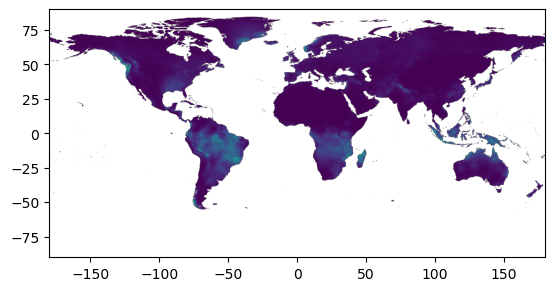

(1, 2160, 4320)


In [ ]:


file = os.path.join(
    data_folder,
    data_files["climate_prec"],
    "wc2.1_cruts4.09_5m_prec_2020-01.tif"
)

src = rasterio.open(file)

plt.figure(figsize=(8, 6))
show(src)
plt.title("Monthly Precipitation - January 2020")
plt.axis("off")
plt.show()

# Checking the number of bands
array = src.read()
print(array.shape)


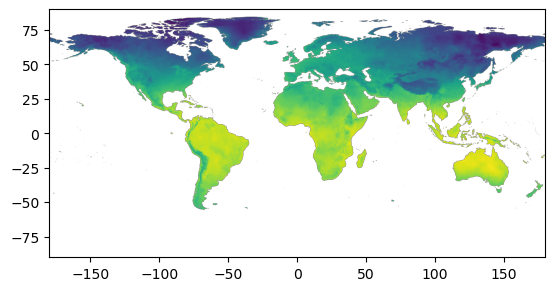

(1, 2160, 4320)


In [ ]:
file = os.path.join(data_folder, data_files["climate_tmin"], "wc2.1_cruts4.09_5m_tmin_2020-01.tif")
src = rasterio.open(file)
show(src)

# Checking the number of bands
array = src.read()
print(array.shape)

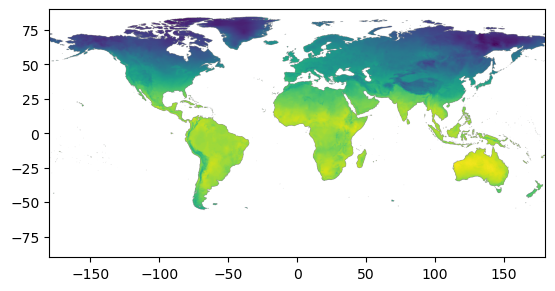

(1, 2160, 4320)


In [ ]:
file = os.path.join(data_folder, data_files["climate_tmax"], "wc2.1_cruts4.09_5m_tmax_2020-01.tif")
src = rasterio.open(file)
show(src)

# Checking the number of bands
array = src.read()
print(array.shape)

### Loading and merging the boundaries of Algeria and Tunisia

In [ ]:
def load_dz_tn_boundaries(dz_shapefile_path, tn_shapefile_path):
    dz = geopandas.read_file(dz_shapefile_path)
    tn = geopandas.read_file(tn_shapefile_path)

    # Ensure both shapefiles use the same CRS 
    if dz.crs != tn.crs:
        tn = tn.to_crs(dz.crs)

    # Concatenate the GeoDataFrames
    boundaries = geopandas.GeoDataFrame(pd.concat([dz, tn], ignore_index=True), crs=dz.crs)

    return boundaries

# Shapefile downloaded from https://gadm.org/

In [ ]:
dz_boundaries_filepath = os.path.join(data_folder, data_files["dz_boundaries"])
tn_boundaries_filepath = os.path.join(data_folder, data_files["tn_boundaries"])

boundaries = load_dz_tn_boundaries(dz_boundaries_filepath, tn_boundaries_filepath)

##### Clipping to the ROI

In [ ]:
def clip_instance(file, boundaries=boundaries):
    with rasterio.open(file) as src:
        # Clip raster with shapefile
        out_image, out_transform = mask(src, boundaries.geometry, crop=True)
        out_meta = src.meta.copy()
    
    # Update metadata
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    return out_image, out_meta

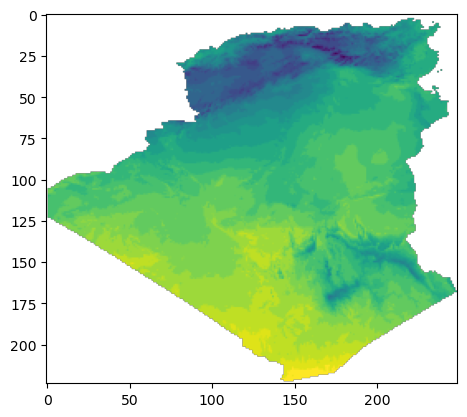

<Axes: >

In [ ]:
# PoC
show(clip_instance(file)[0])

In [ ]:
output_base = os.path.join(output_folder, output_folders["climate"])

for var in ["climate_prec", "climate_tmax", "climate_tmin"]:
    climate_folder = os.path.join(data_folder, data_files[var])

    for filename in os.listdir(climate_folder):
        if filename.endswith(".tif") and "2024" in filename:
            filepath = os.path.join(climate_folder, filename)
            try:
                # Clip raster
                clipped_image, clipped_meta = clip_instance(filepath, boundaries)

                # Save output
                save_path = os.path.join(output_base, var.split("_")[1])  # prec | tmax | tmin
                os.makedirs(save_path, exist_ok=True)

                output_filename = f"clipped_{filename}"
                output_filepath = os.path.join(save_path, output_filename)

                with rasterio.open(output_filepath, "w", **clipped_meta) as dest:
                    dest.write(clipped_image)

                print(f"Saved clipped raster to: {output_filepath}")

            except Exception as e:
                print(f"Error processing {filename}: {e}")

Saved clipped raster to: ../../data/processed/climate/prec/clipped_wc2.1_cruts4.09_5m_prec_2024-05.tif
Saved clipped raster to: ../../data/processed/climate/prec/clipped_wc2.1_cruts4.09_5m_prec_2024-04.tif
Saved clipped raster to: ../../data/processed/climate/prec/clipped_wc2.1_cruts4.09_5m_prec_2024-01.tif
Saved clipped raster to: ../../data/processed/climate/prec/clipped_wc2.1_cruts4.09_5m_prec_2024-03.tif
Saved clipped raster to: ../../data/processed/climate/prec/clipped_wc2.1_cruts4.09_5m_prec_2024-07.tif
Saved clipped raster to: ../../data/processed/climate/prec/clipped_wc2.1_cruts4.09_5m_prec_2024-09.tif
Saved clipped raster to: ../../data/processed/climate/prec/clipped_wc2.1_cruts4.09_5m_prec_2024-02.tif
Saved clipped raster to: ../../data/processed/climate/prec/clipped_wc2.1_cruts4.09_5m_prec_2024-10.tif
Saved clipped raster to: ../../data/processed/climate/prec/clipped_wc2.1_cruts4.09_5m_prec_2024-11.tif
Saved clipped raster to: ../../data/processed/climate/prec/clipped_wc2.1_